<center><h1>Backpropagation From Scratch</h1></center>

<center><h2><a href="https://deepcourse-epita.netlify.app/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://gitlab.com/ey_datakalab/course_epita).

In this notebook, we'll code a **Logistic Regression** and a two-layers **Multi-Layer Perceptron** (MLP) from scratch.

We'll use **pytorch** a deep learning framework. It provides many utilities for neural networks (layers, optimizers, automatic differentiation), but we'll only use its API to manipulate tensors as we would with numpy.

The goal will be to learn a model with **backpropagation** in order to classify digits (0, 1, 2, ..., 9) from images.

---

# 1. Loading Data

In [28]:
%matplotlib inline

In [29]:
import torch
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

In [30]:
X = torch.tensor(digits["images"]).float()
Y = torch.tensor(digits["target"]).long()

print(f"Images shape: {X.shape}, targets shape: {Y.shape}")

Images shape: torch.Size([1797, 8, 8]), targets shape: torch.Size([1797])


We have 1797 images, each of size 8x8. As you see, there is no **channel dimension** meaning that our images are in grayscale. Which is ok for now, as we only want to classify digits.

The targets shape is 1797 because, for each image a target is simply an integer representing the digit.

Now that our data is loaded, we need to visualize it. Always look at your data before doing anything! Something may be wrong with the data (not in this case).

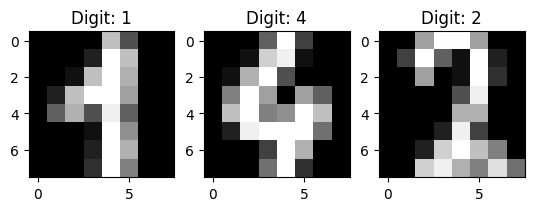

In [31]:
plt.subplot(1, 3, 1)
plt.imshow(X[42], cmap="gray")
plt.title(f"Digit: {Y[42]}");

plt.subplot(1, 3, 2)
plt.imshow(X[64], cmap="gray")
plt.title(f"Digit: {Y[64]}");

plt.subplot(1, 3, 3)
plt.imshow(X[1337], cmap="gray")
plt.title(f"Digit: {Y[1337]}");

For this dataset, the pixels are coded with 4 bits, meaning that we can have values from 0 to 16 ($2^4$). In deep learning, it's very important to normalize the data in order to have all inputs of relatively the same magnitude.

**Beware**: this preprocessing must be done for both the train and test sets! A lot of bugs come from using a slightly different preprocessing between the two sets.

In [32]:
print(f"Min and max value of images pixels [{X.min()}, {X.max()}]")
X = X / 16
print(f"Min and max value of normalized images pixels [{X.min()}, {X.max()}]")

Min and max value of images pixels [0.0, 16.0]
Min and max value of normalized images pixels [0.0, 1.0]


MLP only accepts inputs that are vectors, thus we will flatten our images into vectors:

In [33]:
# Flatten images as vectors
print(f"Images shape: {X.shape}")
X = X.view(X.shape[0], -1)
print(f"Flatten images shape: {X.shape}")

Images shape: torch.Size([1797, 8, 8])
Flatten images shape: torch.Size([1797, 64])


---

# 2. Activation Functions

Now that the data is loaded and preprocessed, we need to code the non-linear activation functions that are essential to deep learning.

First let's start by `softmax`, the final activation, that will give us a probability per digit. It takes as input a vector of **logits** (the final outputs of the network before softmax, one value per digit) and returns a vector of probabilities.

Here is the formula for the $i^\text{th}$ probability:

$$\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [34]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

print(softmax(torch.tensor([1., 2., 3.])))
print(softmax(torch.tensor([3., -0.12, -4.2, 9])))

tensor([0.0900, 0.2447, 0.6652])
tensor([2.4723e-03, 1.0917e-04, 1.8458e-06, 9.9742e-01])


In [35]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_base.py
%pycat softmax_base.py

--2023-10-27 11:36:20--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_base.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.231.252, 18.192.94.96, 2a05:d014:275:cb02::c8, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.231.252|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 155 [text/x-python3]
Saving to: ‘softmax_base.py.1’

softmax_base.py.1   100%[===================>]     155  --.-KB/s    in 0s      

2023-10-27 11:36:21 (115 MB/s) - ‘softmax_base.py.1’ saved [155/155]



def softmax(x):
    e = torch.exp(x)
    return e / e.sum()

print(softmax(torch.tensor([1., 2., 3.])))
print(softmax(torch.tensor([3., -0.12, -4.2, 9])))


Because the output vector is a probability distribution, all individual probabilities should sum to 1, let's check that:

In [36]:
print(softmax(torch.tensor([1., 2., 3.])).sum())
print(softmax(torch.tensor([3., -0.12, -4.2, 9])).sum())

tensor(1.)
tensor(1.)


What if our model is very very confident about class 0:

In [37]:
softmax(torch.tensor([234., 3., 4.]))

tensor([nan, 0., 0.])

Why did we have a NaN? How can we fix it?

Had a NAN because 2²³⁴ is too big for a float32.

In [38]:
def softmax(x):
  max_value = x.max()
  exps = torch.exp(x - max_value)
  return exps / exps.sum()

softmax(torch.tensor([23., 3., 4.]))

tensor([1.0000e+00, 2.0612e-09, 5.6028e-09])

In [39]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_nan.py
%pycat softmax_nan.py

--2023-10-27 11:36:21--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_nan.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.231.252, 18.192.94.96, 2a05:d014:275:cb02::c8, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.231.252|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 143 [text/x-python3]
Saving to: ‘softmax_nan.py.1’

softmax_nan.py.1    100%[===================>]     143  --.-KB/s    in 0s      

2023-10-27 11:36:21 (41,8 MB/s) - ‘softmax_nan.py.1’ saved [143/143]



def softmax(x):
    maximum_value = x.max()
    e = torch.exp(x - maximum_value)
    return e / e.sum()

softmax(torch.tensor([234., 3., 4.]))


Perfectly identical:

$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i - c}}{\sum_j e^{x_j - c}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{-c} e^{x_i}}{e^{-c} \sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$$
$$\operatorname{softmax}(\mathbf{x} - c)_i = \operatorname{softmax}(\mathbf{x})_i$$


In practice, we will have mini-batch, i.e. our probabilities tensor will be of shape $(B, C)$:

In [40]:
x = torch.tensor([
    [1., 2., 3.],
    [4., 9., -12.]
])
probabilities = softmax(x)

print(probabilities.sum())
print(probabilities.sum(dim=1))

tensor(1.0000)
tensor([0.0037, 0.9963])


The whole batch probabilities sum to 1! That's not what we want. What did go wrong? Remember that most pytorch function can be applied only alongside a dimension.

In [41]:
def softmax(x):
  max_value = x.max(dim=1, keepdim=True)[0]
  exps = torch.exp(x - max_value)
  return exps / exps.sum(dim=1, keepdim=True)

x = torch.tensor([
    [1., 2., 3.],
    [4., 9., -12.]
])
probabilities = softmax(x)

print(probabilities.sum(dim=1))

tensor([1., 1.])


In [42]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/softmax_batch.py
%pycat softmax_batch.py

--2023-10-27 11:36:21--  https://deepcourse-epita.netlify.app/code/backpropagation/softmax_batch.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.231.252, 18.192.94.96, 2a05:d014:58f:6202::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.231.252|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 267 [text/x-python3]
Saving to: ‘softmax_batch.py.1’

softmax_batch.py.1  100%[===================>]     267  --.-KB/s    in 0s      

2023-10-27 11:36:22 (268 MB/s) - ‘softmax_batch.py.1’ saved [267/267]



def softmax(x):
    maximum_value = x.max(dim=1, keepdims=True)[0]
    e = torch.exp(x - maximum_value)
    return e / e.sum(dim=1, keepdims=True)

x = torch.tensor([
    [1., 2., 3.],
    [4., 9., -12.]
])
probabilities = softmax(x)

print(probabilities.sum(dim=1))


Now, what about a loss? Let's code the cross-entropy!

Tips:
- Remember about the dimensions, we have mini-batches
- Log of 0 is undefined, what trick can we do then?

In [43]:
def cross_entropy(probs, targets):
    return -torch.sum(targets * torch.log(probs + 1e-8), dim=1)

probs = torch.tensor([
    [0.9, 0.1],
    [0.7, 0.3],
    [0.2, 0.8],
    [0.6, 0.4]
])

targets = torch.eye(2)[torch.tensor([0, 0, 0, 1])]
cross_entropy(probs, targets)

tensor([0.1054, 0.3567, 1.6094, 0.9163])

In [44]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/ce.py
%pycat ce.py

--2023-10-27 11:36:22--  https://deepcourse-epita.netlify.app/code/backpropagation/ce.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.94.96, 18.192.231.252, 2a05:d014:275:cb02::c8, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.94.96|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 271 [text/x-python3]
Saving to: ‘ce.py.1’

ce.py.1             100%[===================>]     271  --.-KB/s    in 0s      

2023-10-27 11:36:22 (208 MB/s) - ‘ce.py.1’ saved [271/271]



def cross_entropy(probs, targets):
    return -torch.sum(targets * torch.log(probs + 1e-8), dim=1)

probs = torch.tensor([
    [0.9, 0.1],
    [0.7, 0.3],
    [0.2, 0.8],
    [0.6, 0.4]
])

targets = torch.eye(2)[torch.tensor([0, 0, 0, 1])]
cross_entropy(probs, targets)


Loss is most important when we are wrong by a large margin. Likewise it is smallest when we are extremely confident. Now you should see that the cross-entropy is maximizing the confidence (also known as the *likelihood*) into the ground-truth class.

Try running the cross-entropy with different probabilities to get an intuition about it.

---

# 3. Logistic Regression

Now that we have our `softmax` activation and `cross-entropy` loss, we can code a **logistic regression**. Behind this fancy name, it's simply a 1-layer neural network followed a softmax.

Here is the forward formula:

$$\tilde{\mathbf{y}} = \mathbf{X}\mathbf{W} + \mathbf{b}$$
$$\hat{\mathbf{y}} = \text{softmax}(\tilde{\mathbf{y}})$$
$$\mathcal{L} = -\frac{1}{B} \sum_{b=1}^B y_b \log \hat{\mathbf{y}}_b $$

With $\mathbf{X} \in \mathbb{R}^{B \times N}$, $\mathbf{W} \in \mathbb{R}^{N \times C}$, and $\mathbf{b} \in \mathbb{R}^{C}$. With $B$ being the batch size, $N$ the number of input pixels, and $C$ the number of classes.

For the backward, We can simplify formulas with a shortcut by taking directly the gradient of the loss $\mathcal{L}$ with relation to (w.r.t) the logits $\tilde{\mathbf{y}}$ (*see course for details*):

$$\nabla_(\tilde{\mathbf{y}}) \mathcal{L} = \hat{\mathbf{y}} - \mathbf{y}$$

Only two gradients are of interest: the one with relation to (w.r.t) the weights $\mathbf{W}$ and $\mathbf{b}$, the neurons we want to update. 

$$\nabla_\mathbf{W} \mathcal{L} = (\nabla_\mathbf{W}(\tilde{\mathbf{y}})^T \nabla_(\tilde{\mathbf{y}})\mathcal{L}$$
$$\nabla_\mathbf{b} \mathcal{L} = \nabla_(\tilde{\mathbf{y}})\mathcal{L}$$

**Hint**: Look at the shape of each tensor if you're confused, i.e., the gradient $\nabla_\mathbf{W} \mathcal{L}$ should have the same shape as $\mathbf{W}$!


We also recall that the gradient with respect to W are a matrix based on $X$ and not simply $X$
$$ \frac{\partial WX + b}{\partial W_{k,l}} = \frac{\sum_{j=1}^{J} W_{k,j} X_{j} + b_k}{\partial W_{k,l}} = X_l
$$


In [45]:
class LogisticRegression:
    def __init__(self, input_size, nb_classes, learning_rate=0.5):
        self.w =  torch.randn(input_size, nb_classes).float()
        self.b =  torch.zeros(nb_classes).float()
        
        self.learning_rate = learning_rate
        self.nb_classes = nb_classes
        
    def forward(self, x):
        return  torch.mm(x, self.w) + self.b
    
    def fit(self, inputs, targets, train=True):
        probs = softmax(self.forward(inputs))
        if train:
            self.backward(inputs, probs, targets)

        loss = cross_entropy(probs, torch.eye(self.nb_classes)[targets]).mean()
        return loss
    
    def backward(self, inputs, probs, targets):
        batch_size = inputs.shape[0]
        
        grad_logits = probs - torch.eye(self.nb_classes)[targets]
        grad_w = torch.mm(inputs.T, grad_logits) / batch_size
        grad_b = grad_logits.mean(dim=0)

        self.w -= self.learning_rate * grad_w
        self.b -= self.learning_rate * grad_b
        
    def accuracy(self, inputs, targets):
        probs = softmax(self.forward(inputs))
        predictions = probs.argmax(dim=1)
        return (predictions == targets).float().mean()

In [46]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://deepcourse-epita.netlify.app/code/backpropagation/logreg.py
%pycat logreg.py

--2023-10-27 11:36:22--  https://deepcourse-epita.netlify.app/code/backpropagation/logreg.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.94.96, 18.192.231.252, 2a05:d014:58f:6202::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.94.96|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 1086 (1,1K) [text/x-python3]
Saving to: ‘logreg.py.1’

logreg.py.1         100%[===================>]   1,06K  --.-KB/s    in 0s      

2023-10-27 11:36:22 (5,93 MB/s) - ‘logreg.py.1’ saved [1086/1086]



class LogisticRegression:
    def __init__(self, input_size, nb_classes, learning_rate=0.01):
        self.w = torch.randn(input_size, nb_classes).float()
        self.b = torch.zeros(nb_classes).float()

        self.learning_rate = learning_rate

    def forward(self, x):
        return torch.mm(x, self.w) + self.b

    def fit(self, inputs, targets, train=True):
        probs = softmax(self.forward(inputs))
        if train:
            self.backward(inputs, probs, targets)

        loss = cross_entropy(probs, torch.eye(10)[targets]).mean()
        return loss

    def backward(self, inputs, probs, targets):
        batch_size = len(inputs)

        grad_logits = probs - torch.eye(10)[targets]
        grad_w = torch.mm(inputs.T, grad_logits) / batch_size
        grad_b = torch.sum(grad_logits, dim=0) / batch_size

        self.w = self.w - self.learning_rate * grad_w
        self.b = self.b - self.learning_rate * grad_b

    def accuracy(self, inputs, targets):
        y_pred = self

In [47]:
model = LogisticRegression(X.shape[1], len(torch.unique(Y)), 0.5)

Let's measure the accuracy of the untrained model. What does it, roughtly, correspond to? Any idea why?

In [48]:
model.accuracy(X, Y)

tensor(0.0473)

Let's train! We are going to see the whole dataset `nb_epochs` times, by chunk of `batch_size` images.

**Note** that we are training and testing on the same set here for simplicity, but in later courses, or in real-life, don't do that.

Epoch: 0, loss: 0.9488064050674438, accuracy: 0.6816917061805725
Epoch: 1, loss: 0.5328096151351929, accuracy: 0.8375069499015808
Epoch: 2, loss: 0.40273523330688477, accuracy: 0.8842515349388123
Epoch: 3, loss: 0.3370334804058075, accuracy: 0.902615487575531


Epoch: 4, loss: 0.29546335339546204, accuracy: 0.9143016338348389
Epoch: 5, loss: 0.26609429717063904, accuracy: 0.9198664426803589
Epoch: 6, loss: 0.24399560689926147, accuracy: 0.9293266534805298
Epoch: 7, loss: 0.22664225101470947, accuracy: 0.9332220554351807
Epoch: 8, loss: 0.21257391571998596, accuracy: 0.9382303953170776
Epoch: 9, loss: 0.20087961852550507, accuracy: 0.9421257376670837


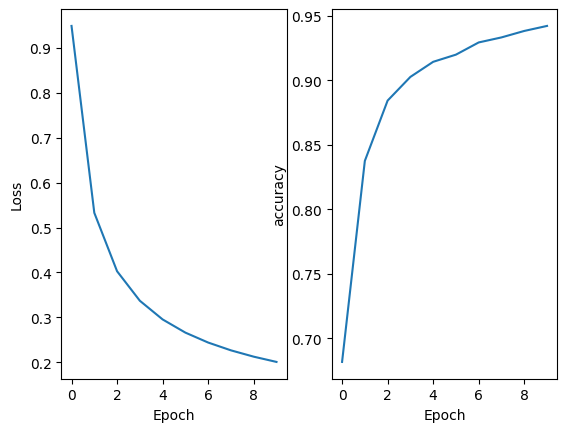

In [49]:
batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]
    
        loss = model.fit(batch_X, batch_Y)
        
    loss = model.fit(X, Y, train=False)
    acc = model.accuracy(X, Y)
    
    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)
    
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

--- 

# 4. Multi-Layer Perceptron

Now, let's build a Multi-Layer Perceptron, aka a neural network with hidden layers.

Hidden layers imply hidden activations. `tanh` is already implemented for you: `torch.tanh`.

This function is applied **element-wise**, meaning that it is applied independently on every point of the tensor (not like softmax). We now need the gradient of this function:

In [50]:
def grad_tanh(tanh_results):
    return 1 - tanh_results ** 2

In [51]:
# Execute this cell to see the solution, but try to do it by yourself before!
# !wget https://deepcourse-epita.netlify.app/code/backpropagation/gradtanh.py
# %pycat gradtanh.py

--2023-10-27 11:36:23--  https://deepcourse-epita.netlify.app/code/backpropagation/gradtanh.py
Resolving deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)... 18.192.94.96, 18.192.231.252, 2a05:d014:58f:6202::64, ...
Connecting to deepcourse-epita.netlify.app (deepcourse-epita.netlify.app)|18.192.94.96|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 62 [text/x-python3]
Saving to: ‘gradtanh.py.1’

gradtanh.py.1       100%[===================>]      62  --.-KB/s    in 0s      

2023-10-27 11:36:23 (14,3 MB/s) - ‘gradtanh.py.1’ saved [62/62]



def grad_tanh(tanh_results):
    return 1 - tanh_results ** 2


Now the MLP is like the Logistic Regression we coded previously, but with hidden layers!

We'll only start with one hidden layer to start. The forward should be straightforward, and for the backward try to derive it by yourself. If you're really stuck, you can have a look at the code solution, or the course. But after you've tried enough!

In [52]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, nb_classes, learning_rate=0.5):
        super(MLP, self).__init__()
        self.w_hidden =  torch.randn(input_size, hidden_size).float()
        self.b_hidden =  torch.zeros(hidden_size).float()
        
        self.w_output =  torch.randn(hidden_size, nb_classes).float()
        self.b_output =  torch.zeros(nb_classes).float()
        
        self.learning_rate = learning_rate
        self.nb_classes = nb_classes
        
    def forward(self, x):
        h = torch.tanh(torch.mm(x, self.w_hidden) + self.b_hidden)
        return torch.mm(h, self.w_output) + self.b_output, h
       # Remember to keep all intermediary values that are needed for the backward pass
        
    def fit(self, inputs, targets, train=True):
        logits, h = self.forward(inputs)
        probs = softmax(logits)
        h_tilde = torch.tanh(torch.mm(inputs, self.w_hidden) + self.b_hidden)
        if train:
            self.backward(inputs, targets, h_tilde, h, logits, probs)

        loss = cross_entropy(probs, torch.eye(self.nb_classes)[targets]).mean()
        return loss
    
    def backward(self, inputs, targets, h_tilde, h, logits, probs):
        batch_size = inputs.shape[0]

        grad_logits = probs - torch.eye(self.nb_classes)[targets]
        grad_w_output = torch.mm(h.T, grad_logits) / batch_size
        grad_b_output = grad_logits.mean(dim=0)
        grad_h = torch.mm(grad_logits, self.w_output.T)
        grad_h_tilde = grad_h * grad_tanh(h_tilde)
        grad_w_hidden = torch.mm(inputs.T, grad_h_tilde) / batch_size

        self.w_hidden -= self.learning_rate * grad_w_hidden
        self.b_hidden -= self.learning_rate * grad_h_tilde.mean(dim=0)
        self.w_output -= self.learning_rate * grad_w_output
        self.b_output -= self.learning_rate * grad_b_output
        
    def accuracy(self, inputs, targets):
        logits, _ = self.forward(inputs)
        probs = softmax(logits)
        predictions = probs.argmax(dim=1)
        return (predictions == targets).float().mean()

The same code used for the Logisitic Regression can also be used for the MLP.

That's the beauty of it, as long as our model can take in inputs images and predicts their digits, we don't care about the internals in the training loops:

Epoch: 0, loss: 0.9655445218086243, accuracy: 0.7562604546546936
Epoch: 1, loss: 0.4117208421230316, accuracy: 0.8681135177612305


Epoch: 2, loss: 0.23174256086349487, accuracy: 0.915414571762085
Epoch: 3, loss: 0.18020980060100555, accuracy: 0.9404563307762146
Epoch: 4, loss: 0.1470729559659958, accuracy: 0.9499165415763855
Epoch: 5, loss: 0.12420552223920822, accuracy: 0.9554813504219055
Epoch: 6, loss: 0.10792649537324905, accuracy: 0.9638286232948303
Epoch: 7, loss: 0.09525055438280106, accuracy: 0.9649415612220764
Epoch: 8, loss: 0.08470064401626587, accuracy: 0.9705063700675964
Epoch: 9, loss: 0.07564476132392883, accuracy: 0.9738453030586243


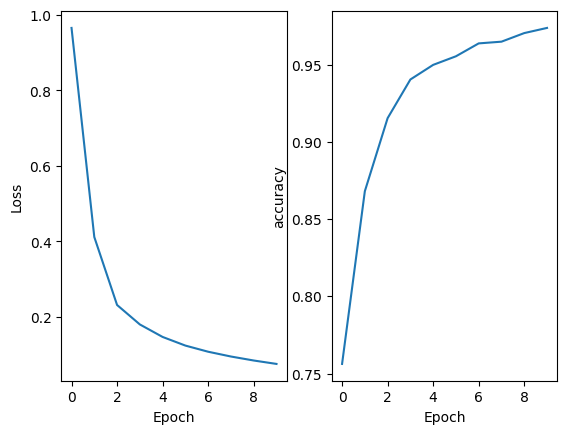

In [53]:
model = MLP(X.shape[1], 50, len(torch.unique(Y)), 0.5)
model.accuracy(X, Y)

batch_size = 32
nb_epochs = 10

epochs, accuracies, losses = [], [], []

for epoch in range(nb_epochs):
    for batch_index in range(0, len(X), batch_size):
        batch_X = X[batch_index:batch_index + batch_size]
        batch_Y = Y[batch_index:batch_index + batch_size]
    
        model.fit(batch_X, batch_Y)
        
    loss = model.fit(X, Y, train=False)
    acc = model.accuracy(X, Y)
    
    print(f"Epoch: {epoch}, loss: {loss}, accuracy: {acc}")
    epochs.append(epoch)
    losses.append(loss)
    accuracies.append(acc)
    
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("accuracy");

In [56]:
# !pip install onnx

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for onnx from https://files.pythonhosted.org/packages/e6/74/522f651adbcd4b6d359b1a3e381185f8e1cd0ada8e9a97465a1990855dff/onnx-1.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 18.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [57]:
# Save the model as onnx
import torch.onnx
torch.onnx.export(model, X, "Models/model_backprop.onnx", input_names = ['input_digits'], output_names = ['output'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



![MLP model](Models/model_backprop)

--- 

# Notebook Summary

We learn how to:
- code a robust softmax
- logistic regression with forward and backward pass
- MLP with forward and backward pass

# Further Works

- Try to implement a MLP with two hidden layers, or three, or as much as the user want, through a simple API.
- Does the initialization of the weights matter? Try tweaking it (more on it in later courses)